# Inception - V3

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import cv2
from PIL import Image
from tensorflow.keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn import metrics
import itertools
import re
from keras.layers import Input, ZeroPadding2D, BatchNormalization, Activation, Add, AveragePooling2D, concatenate
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model

import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading the saved file once again
tumor_final = np.load(os.path.join('/Users/balaj/OneDrive/Desktop/Docs/Docs 1/SMU/Capstone A/Code','features.npy'), 
                allow_pickle=True)

#loading the saved file once again
target = np.load(os.path.join('/Users/balaj/OneDrive/Desktop/Docs/Docs 1/SMU/Capstone A/Code','target.npy'), 
                allow_pickle=True)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(tumor_final, target, test_size=0.2, random_state=42)

print(pd.DataFrame(Y_test)[0].value_counts())

print(pd.DataFrame(Y_train)[0].value_counts())

# random shuffling the training images and target
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = np.array(Y_train)[s]

# random shuffling the Test images and target
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = np.array(Y_test)[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

1    266
0    137
Name: 0, dtype: int64
1    1124
0     486
Name: 0, dtype: int64


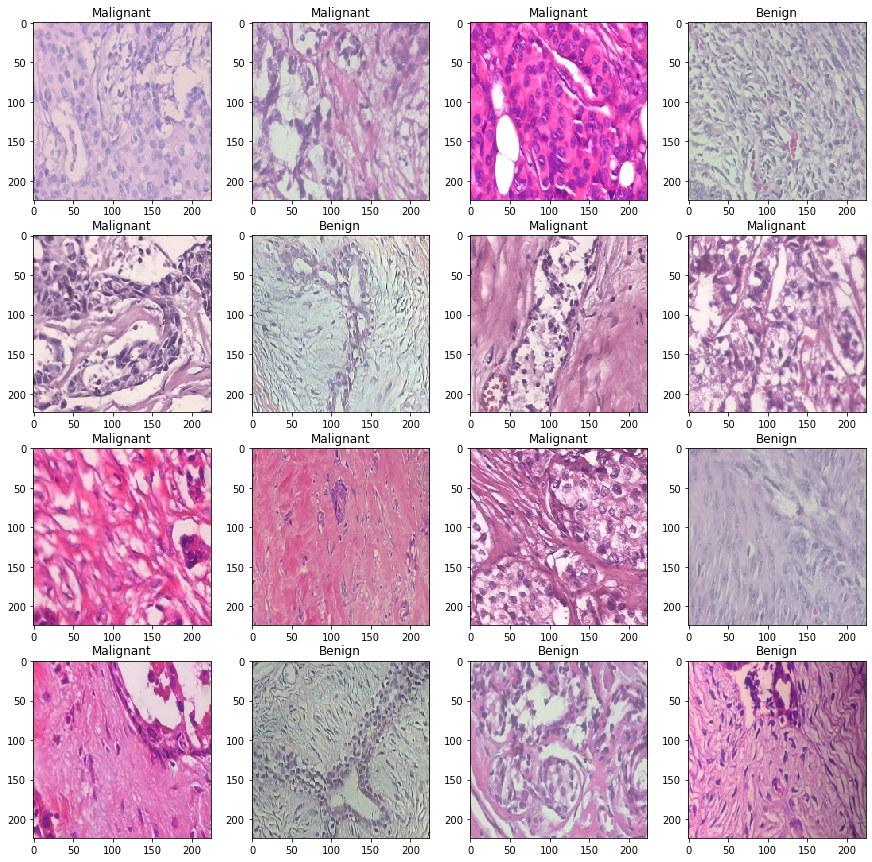

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [5]:
from IPython.display import Image
from IPython.display import display
x=Image(url="images/inceptionv3.png", width=900)
display(x)

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [7]:
#inception naive version

def inception_module(x, f1, f2, f3):
	# 1x1 conv
	conv1 =  keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
	# 3x3 conv
	conv3 = keras.layers.Conv2D(f2, (3,3), padding='same', activation='relu')(x)
	# 5x5 conv
	conv5 = keras.layers.Conv2D(f3, (5,5), padding='same', activation='relu')(x)
	# 3x3 max pooling
	pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
	# concatenate filters
	out = keras.layers.merge.concatenate([conv1, conv3, conv5, pool])
	return out

In [8]:
img_input =Input(shape=(224, 224, 3))
classes=1000
channel_axis=3

In [9]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    x = Activation('relu')(x)
    return x

# num_row and num_cols are height and width of filter

# Building a model layer by layer

In [10]:
def inc_block_a(x):    
    branch1x1 = conv2d_bn(x, 64, 1, 1)  # 64 filters of 1*1

    branch5x5 = conv2d_bn(x, 48, 1, 1)  #48 filters of 1*1
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis)
    return x

In [11]:
def reduction_block_a(x):  
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
    return x

In [12]:
# 17 x 17 x 768
def inc_block_b(x):
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=channel_axis)
    return x

In [13]:
# mixed 8: 8 x 8 x 1280
def reduction_block_b(x): 
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn( branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([branch3x3, branch7x7x3, branch_pool], axis=channel_axis)
    return x


In [14]:
def inc_block_c(x):  
    
    branch1x1 = conv2d_bn(x, 320, 1, 1)

    branch3x3 = conv2d_bn(x, 384, 1, 1)
    branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
    branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
    branch3x3 = concatenate([branch3x3_1, branch3x3_2],axis=channel_axis)

    branch3x3dbl = conv2d_bn(x, 448, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
    branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
    branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
    branch3x3dbl = concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate( [branch1x1, branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
    return x

In [15]:
img_input = Input(shape=(224, 224, 3))  #shape=(None, 299, 299, 3)  

In [16]:
def inception(input_shape=(64, 64, 3),classes=2):
    # input image size: 299 x 299 x 3
    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid') # 149 x 149 x 32
    x = conv2d_bn(x, 32, 3, 3, padding='valid')  # 147 x 147 x 32
    x = conv2d_bn(x, 64, 3, 3) # 147 x 147 x 64
        
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)   # 73  x 73 x 64
    x = conv2d_bn(x, 80, 1, 1, padding='valid') # 73 x 73 x 80
    x = conv2d_bn(x, 192, 3, 3, padding='valid')  # 71 x 71 x 192
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)  # 35 x 35 x 192

    x=inc_block_a(x) #35, 35, 256
    x=inc_block_a(x) #35, 35, 256
    x=inc_block_a(x) #35, 35, 256

    x=reduction_block_a(x) #17, 17, 736

    x=inc_block_b(x) #17, 17, 768
    x=inc_block_b(x) #17, 17, 768
    x=inc_block_b(x) #17, 17, 768
    x=inc_block_b(x) #17, 17, 768

    x=reduction_block_b(x) #shape=(None, 8, 8, 1280)

    x=inc_block_c(x) # shape=(None, 8, 8, 2048) 
    x=inc_block_c(x) # shape=(None, 8, 8, 2048) 

    x = GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)

    x = Dense(classes, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

    model = Model(inputs = img_input, outputs = x, name='inceptionv3')
    
    return model

In [17]:
inceptionv3_model = inception(input_shape = (224, 224, 3), classes = 2)

In [18]:
lr=1e-4
inceptionv3_model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
inceptionv3_model.summary()

Model: "inceptionv3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                       

In [20]:
# Generate batches of tensor image data with real-time data augmentation.

BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range=0.7,
        brightness_range=[0.2,0.6]
    )

In [ ]:
# Reduce learning rate when a metric has stopped improving.
learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Callback to save the Keras model or model weights at some frequency.
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = inceptionv3_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
80/80 [==============================] - 330s 4s/step - loss: 0.5654 - accuracy: 0.7725 - val_loss: 0.7396 - val_accuracy: 0.6957 - lr: 1.0000e-04
Epoch 2/20
80/80 [==============================] - 331s 4s/step - loss: 0.4669 - accuracy: 0.8028 - val_loss: 0.6525 - val_accuracy: 0.6957 - lr: 1.0000e-04
Epoch 3/20
80/80 [==============================] - 324s 4s/step - loss: 0.4756 - accuracy: 0.8090 - val_loss: 8.6030 - val_accuracy: 0.3075 - lr: 1.0000e-04
Epoch 4/20
80/80 [==============================] - 339s 4s/step - loss: 0.4545 - accuracy: 0.7997 - val_loss: 7.4606 - val_accuracy: 0.6957 - lr: 1.0000e-04
Epoch 5/20
80/80 [==============================] - 383s 5s/step - loss: 0.4308 - accuracy: 0.8214 - val_loss: 1.3731 - val_accuracy: 0.7360 - lr: 1.0000e-04
Epoch 6/20
80/80 [==============================] - 361s 4s/step - loss: 0.4220 - accuracy: 0.8292 - val_loss: 22.0624 - val_accuracy: 0.6957 - lr: 1.0000e-04
Epoch 7/20
81/80 [==============================] -

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
y_pred=inceptionv3_model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()